<a href="https://colab.research.google.com/github/vasyl-d/Google-Apps-Script-Telegram-Bot-Library/blob/master/Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023-03-01 2023-03-10
Total orders count 406
Notebook orders count 46


,id,created,status,client,ad,group,brand,total
0,T6442,1.3.2023,Закрито видано Клієнту,Юлия,Интернет,Ноутбук,Hewlett-packard,3840.0
1,S4805401,1.3.2023,Закрито видано Клієнту,Олександр,Интернет,Ноутбук,Lenovo,790.0
2,S4805501,1.3.2023,Закрито видано Клієнту,Ярослав,Интернет,Ноутбук,Dell,1200.0
3,S4805601,1.3.2023,Закрито видано Клієнту,Ксенія,Интернет,Ноутбук,Asus,1200.0
4,S4805701,1.3.2023,Закрито видано Клієнту,Сахно Жанна,Интернет,Ноутбук,Lenovo,1600.0
5,S4805801,1.3.2023,Закрито видано Клієнту,Коноваленко Михайло Валерійович,Живу поруч,Ноутбук,Asus,2390.0
6,S4806101,1.3.2023,Закрито видано Клієнту,Іван,Интернет,Ноутбук,Lenovo,800.0
7,S4806901,1.3.2023,Закрито видано Клієнту,Володимир,Интернет,Ноутбук,clevo,990.0
8,S4807301,1.3.2023,🏆Готово. В обробці.,Товариство з обмеженою відповідальністю «Рейка...,Интернет,Ноутбук,Asus,3000.0
9,T6463,1.3.2023,🏆 Готово,"ТОВ ""СМАРТІВЕЙ ЮКРЕЙН""",Интернет,Ноутбук,Acer,1490.0


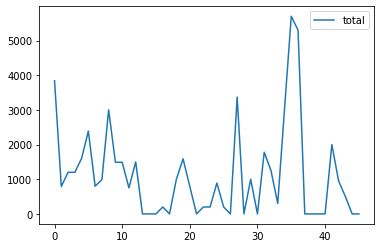

In [64]:
from numpy import true_divide
#@title Строим отчет по типу устройства в заказе

assetType = "\u041D\u043E\u0443\u0442\u0431\u0443\u043A" #@param {type:"string"}
apiKey = "f0b3e83a73964060b1cfc68c43802e42" #@param {type: "string"}
dateFrom = "2023-03-01" #@param {type:"date"}
dateTo = "2023-03-10" #@param {type:"date"}

import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

print(dateFrom, dateTo)
(y,m,d) = map(int, dateFrom.split('-'))
dayFromInt = int(time.mktime((y,m,d, 0,0,0,0,0,0))*1000)

(y,m,d) = map(int, dateTo.split('-'))
dayToInt = int(time.mktime((y,m,d, 0,0,0,0,0,0))*1000)

def getToken(apiKey):
  url = 'https://api.remonline.app/token/new'
  token = None
  payload={'api_key': apiKey}
  files=[

  ]
  headers = {}
  try:
      response = requests.request("POST", url, headers=headers, data=payload, files=files)
      response.raise_for_status()
      data = response.json()
      token = data["token"]
  except Exception as error:
      print(error)
  return token

def getOrders(token):
  page = 1
  url = f"https://api.remonline.app/order/?created_at[]={dayFromInt}&created_at[]={dayToInt}&token={token}&page={page}"
  payload={}
  files=[

  ]
  headers = {}
  retData = []
  payload = {}
  try:
    response = requests.request("GET", url, headers=headers, data=payload, files=files)
    response.raise_for_status()
    data = response.json()
    count = int(data.get('count', 0))
    retData = data.get("data",[])
    page = 2
    while count//50 + 1 >= page:
      url = f"https://api.remonline.app/order/?created_at[]={dayFromInt}&created_at[]={dayToInt}&token={token}&page={page}"
      response = requests.request("GET", url, headers=headers, data=payload, files=files)
      response.raise_for_status()
      data = response.json()
      retData.extend(data.get("data",[]))
      page += 1
  except Exception as error:
      print(error)
  return retData

def mkDate(tm):
  y, m, d, *rest = time.localtime(tm/1000)
  return f"{d}.{m}.{y}"

def getProductsPrice(pr):
  return round(sum(el.get('price') *el.get('amount') - el.get('discount_value') for el in pr), 2)


token = getToken(apiKey)
orders = getOrders(token)
print('Total orders count', len(orders))

res = [(el.get('id_label'), mkDate(el.get('created_at')),el.get('status').get('name'), 
        el.get('client').get('name'),el.get('ad_campaign').get('name'), 
        el.get('asset').get('group'), el.get('asset').get('brand'),
        getProductsPrice(el.get('parts'))+getProductsPrice(el.get('operations'))) for el in filter(lambda x: x.get('asset').get('group') == assetType, orders)]

print('Notebook orders count', len(res))

res1 = pd.DataFrame(res, columns = ["id", "created", "status", "client", "ad", "group" ,"brand", "total"])

res1.plot()

from google.colab import data_table
data_table.DataTable(res1, include_index=True, num_rows_per_page=10)


